In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")
from Analysis.utils import (
    filter_opto_data,
    get_running_valid_intervals,
    bootstrap_traces,
)
from AnalysisTables.decoding_tables import ClusterlessAheadBehindDistance
from AnalysisTables.credible_intervals import (
    CredibleInterval,
    CredibleIntervalSelection,
)
from AnalysisTables.place_fields import TrackCellCoverage

from Style.style_guide import animal_style, transfection_style
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.common import interval_list_contains
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup

from AnalysisTables.valid_decode_times import ClusterlessValidDecodeTimes


from tqdm import tqdm
import pandas as pd

[2025-04-14 09:20:00,398][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-04-14 09:20:00,538][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


In [2]:
# %%snakeviz
dlc_pos = True
posterior_fit = "causal"
compiled_results = []
animal_list = [
    "Winnie",
]  # "Yoshi"]
animal_list = animal_style.index

animal_list = ["transfected", "control"]
spikes_delta_t = 0.0005
plot_ind = np.arange(-35, 35, 1)
spikes_window = int(plot_ind[-1] * (0.002 / spikes_delta_t))
spikes_plot_ind = np.arange(-spikes_window, spikes_window, 1)

for animal in animal_list:
    dataset_key = {
        "animal": animal,
        "track_type": "early_wtrack",
        # "track_type": "lineartrack",
        # "period_ms": 100,
        "min_pulse_length": 20,
    }
    if animal in [x["animal"] for x in compiled_results]:
        continue

    dataset = filter_opto_data(dataset_key)
    dataset = dataset.proj(decoding_interval="interval_list_name")
    dataset = ClusterlessValidDecodeTimes() & dataset
    if dlc_pos:
        dataset = dataset & "position_group_name LIKE 'DLC%'"
    if not dataset:
        continue

    state_response = []
    entropy = []
    mua = []
    ahead_behind = []
    decode_credible_coverage = []
    for ii, key in enumerate(tqdm(dataset.fetch("KEY")[:])):
        # break
        stim = (ClusterlessValidDecodeTimes() & key).fetch1("valid_stim_times")
        if len(stim) == 0:
            continue
        if not (ClusterlessAheadBehindDistance() & key):
            continue
        track_key = {
            "nwb_file_name": key["nwb_file_name"],
            "decode_group_name": key["position_group_name"],
        }
        track_query = TrackCellCoverage & track_key
        if not track_query:
            continue
        good_coverage_times = track_query.fetch_good_coverage_times()
        stim = interval_list_contains(good_coverage_times, np.array(stim))
        if len(stim) == 0:
            continue

        results = (ClusterlessDecodingV1 & key).fetch_results()
        timestamps = results.time
        ind_on = np.digitize(stim, timestamps)

        if posterior_fit == "acausal":
            results = results.acausal_posterior
        elif posterior_fit == "causal":
            results = results.causal_posterior
        else:
            raise ValueError("Invalid posterior_fit: {}".format(posterior_fit))
        unstacked_result_states = results.unstack("state_bins")
        states = unstacked_result_states.state.values
        state_probabilities = unstacked_result_states.sum("position")[0]
        position_posterior = unstacked_result_states.sum("state")[0]
        entropy_i = -np.sum(position_posterior * np.log(position_posterior), axis=-1)

        state_response.extend([state_probabilities[ind + plot_ind] for ind in ind_on])
        entropy.extend([entropy_i[ind + plot_ind] for ind in ind_on])

        # mua
        # spikes = ClusterlessDecodingV1().fetch_spike_data(key)[0]
        # flat_spikes = np.concatenate(spikes)
        # spike_inds = np.digitize(flat_spikes, timestamps)
        # mua_i = np.bincount(spike_inds, minlength=len(timestamps))

        sort_interval = key["waveform_features_group_name"]
        spikes_key = {
            "nwb_file_name": key["nwb_file_name"],
            "sorted_spikes_group_name": sort_interval,
            "unit_filter_params_name": "default_exclusion",
        }
        if not (group_query := (SortedSpikesGroup() & spikes_key)):
            continue
        spikes_key = group_query.fetch1("KEY")
        spikes_timestamps = np.arange(timestamps[0], timestamps[-1], spikes_delta_t)
        mua_i = SortedSpikesGroup().get_firing_rate(
            spikes_key, spikes_timestamps, multiunit=True, smoothing_sigma=0.001
        )
        spikes_ind_on = np.digitize(stim, spikes_timestamps)
        assert len(spikes_ind_on) == len(ind_on)
        mua.extend([mua_i[ind + spikes_plot_ind] for ind in spikes_ind_on])

        ahead_behind_df = (ClusterlessAheadBehindDistance() & key).fetch1_dataframe()
        ahead_behind.extend(
            [
                ahead_behind_df["decode_distance"].values[ind + plot_ind]
                for ind in ind_on
            ]
        )

        # decode_credible_coverage
        coverage_df = (CredibleInterval & key).fetch1_dataframe()
        decode_credible_coverage.extend(
            [coverage_df["coverage"].values[ind + plot_ind] for ind in ind_on]
        )
        # break

    state_response = np.array(state_response)
    entropy = np.array(entropy)
    mua = np.array(mua)
    ahead_behind = np.array(ahead_behind)
    decode_credible_coverage = np.array(decode_credible_coverage)
    compiled_results.append(
        {
            "animal": animal,
            "state_response": state_response,
            "entropy": entropy,
            "mua": mua,
            "ahead_behind": ahead_behind,
            "coverage": decode_credible_coverage,
        }
    )

compiled_results = pd.DataFrame(compiled_results)

datasets: 44


  0%|          | 0/28 [00:00<?, ?it/s][2025-04-14 09:22:02,062][WARNING]: Skipped checksum for file with hash: f16f137d-706e-b69f-7026-808cae7a30cc, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_dbc0d72d-7679-4afe-8848-b991555ed9a9.nc
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/xarray/namedarray/core.py:496: UserWarning: Duplicate dimension names present: dimensions {'states'} appear more than once in dims=('states', 'states'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.warn(
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/xarray/namedarray/core.py:496: UserWarning: Duplicate dimension names

datasets: 42


  0%|          | 0/40 [00:00<?, ?it/s][2025-04-14 10:18:14,530][WARNING]: Skipped checksum for file with hash: b012270a-2892-dbf5-1e7c-7128954a5bcf, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_1f21c8cf-ca91-43b0-9e7e-1c45e0f0fa14.nc
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/xarray/namedarray/core.py:496: UserWarning: Duplicate dimension names present: dimensions {'states'} appear more than once in dims=('states', 'states'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.warn(
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/xarray/namedarray/core.py:496: UserWarning: Duplicate dimension names

In [26]:
# compiled_resu
compiled_animals = [q["animal"] for q in compiled_results]
compiled_animals

TypeError: string indices must be integers

In [ ]:
state_response = np.array(state_response)
entropy = np.array(entropy)
mua = np.array(mua)
ahead_behind = np.array(ahead_behind)
decode_credible_coverage = np.array(decode_credible_coverage)
compiled_results.append(
    {
        "animal": animal,
        "state_response": state_response,
        "entropy": entropy,
        "mua": mua,
        "ahead_behind": ahead_behind,
        "coverage": decode_credible_coverage,
    }
)

compiled_results = pd.DataFrame(compiled_results)

transfected, n = 2161
control, n = 11016


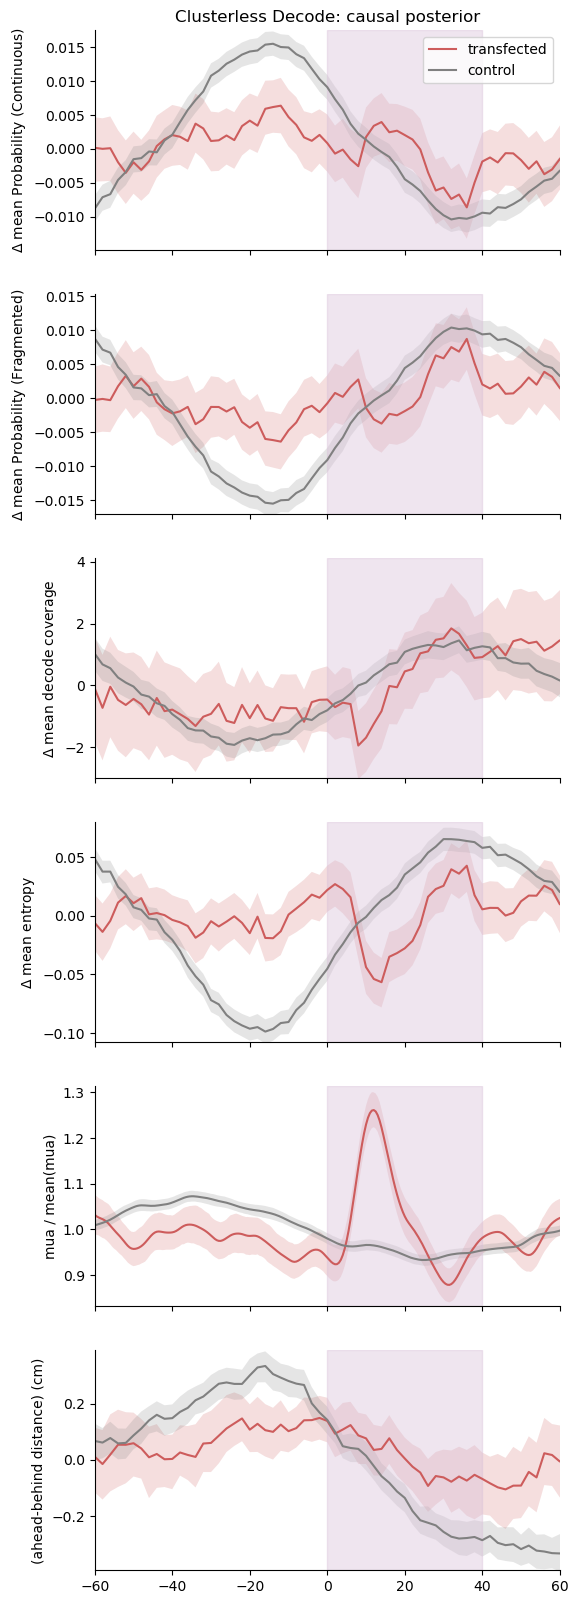

In [3]:
# mua_smooth = 3
non_local_threshold = None  # 10
abs_ahead_behind = False

fig, ax = plt.subplots(
    # nrows=state_probabilities.shape[-1] + 3, sharex=True, figsize=(6, 20)
    nrows=2 + 4,
    sharex=True,
    figsize=(6, 20),
)
# fig, ax = plt.subplots(
#     nrows=3, ncols=2, sharex=True, figsize=(6, 15)
# )
# ax = np.ravel(ax)

n_boot = 1000
# n_boot = 30

lo = [1000 for _ in ax]
hi = [-1000 for _ in ax]
coverage_ind = -4
entropy_ind = -3
mua_ind = -2
distance_ind = -1
from Analysis.utils import smooth

for (
    animal,
    state_response,
    entropy,
    mua,
    ahead_behind,
    coverage,
) in compiled_results.values:
    color = animal_style.loc[animal]["color"]
    # color = transfection_style[animal]

    for i, a in enumerate(ax[: state_response.shape[-1]]):
        # yy = np.nanmean(state_response-np.mean(state_response,axis=1)[:,None,:], axis=0)[:, i]
        # yy = np.nanmean(state_response, axis=0)[:, i]
        # yy = yy-np.mean(yy)
        # lo[i] = min(yy.min() * 0.99, lo[i])
        # hi[i] = max(yy.max() * 1.01, hi[i])

        yy = (
            state_response[..., i] - np.mean(state_response[..., i], axis=1)[:, None]
        )  # / -np.mean(state_response[..., i], axis=1)[:, None]
        yy, rng = bootstrap_traces(yy, n_boot=n_boot)

        lo[i] = min(rng[0].min() * 0.99, lo[i])
        hi[i] = max(rng[1].max() * 1.01, hi[i])
        # color = animal_style.loc[animal]["color"]
        a.plot(plot_ind * 2, yy, color=color, label=animal, lw=1.5)
        a.fill_between(plot_ind * 2, *rng, facecolor=color, alpha=0.2)
        a.set_ylabel(f"$\Delta$ mean Probability ({states[i]})")
    # # entropy
    # yy = np.nanmean(entropy, axis=0)
    # yy = yy-np.mean(yy)
    yy = entropy - np.mean(entropy, axis=1)[:, None]  # / np.mean(entropy, axis=1)[
    #     :, None
    # ]
    yy, rng = bootstrap_traces(yy, n_boot=n_boot)
    lo[entropy_ind] = min(rng[0].min() * 0.99, lo[entropy_ind])
    hi[entropy_ind] = max(rng[1].max() * 1.01, hi[entropy_ind])
    ax[entropy_ind].plot(plot_ind * 2, yy, color=color, label=animal)
    ax[entropy_ind].fill_between(plot_ind * 2, *rng, facecolor=color, alpha=0.2)

    # # mua
    # # yy = np.nanmean(entropy, axis=0)
    # # yy = yy-np.mean(yy)
    # yy = (np.array(mua) - np.mean(mua, axis=1)[:, None]) / np.mean(mua, axis=1)[:, None]
    # yy = np.array([smooth(y_, mua_smooth) for y_ in yy])
    yy = mua
    yy = np.array([smooth(y_, sigma=7, n=20) for y_ in yy])
    empty = np.squeeze(yy.sum(axis=1) <= 30)
    yy = yy[~empty]
    yy = yy / np.nanmean(yy, axis=1)[:, None]
    # yy = np.array([smooth(y_, 5) for y_ in yy])
    # yy_mean = np.nanmean(yy, axis=1)
    # yy = (yy - yy_mean[:, None]) / (yy_mean[:, None]+1e-1)
    yy, rng = bootstrap_traces(yy, n_boot=n_boot)
    lo[mua_ind] = min(rng[0].min() * 0.99, lo[mua_ind])
    hi[mua_ind] = max(rng[1].max() * 1.01, hi[mua_ind])
    ax[mua_ind].plot(
        spikes_plot_ind * 1000 * spikes_delta_t, yy, color=color, label=animal
    )
    ax[mua_ind].fill_between(
        spikes_plot_ind * 1000 * spikes_delta_t,
        np.squeeze(rng[0]),
        np.squeeze(rng[1]),
        facecolor=color,
        alpha=0.2,
    )

    # # ahead-behind distance
    if abs_ahead_behind:
        ahead_behind = np.abs(ahead_behind)
    ahead_behind = np.clip(ahead_behind, -20, 20)
    if non_local_threshold is None:
        yy = ahead_behind - np.mean(ahead_behind, axis=1)[:, None] * 1
    else:
        yy = (np.abs(ahead_behind) > non_local_threshold).astype(float) - np.mean(
            (np.abs(ahead_behind) > non_local_threshold).astype(float), axis=1
        )[:, None]

    # yy = np.abs(ahead_behind) #- np.mean(np.abs(ahead_behind), axis=1)[:, None]
    # yy = np.array([smooth(y_, 5) for y_ in yy])
    # yy = ahead_behind
    # yy = np.abs(yy)
    yy, rng = bootstrap_traces(yy, n_boot=n_boot, statistic=np.median)
    lo[distance_ind] = min(rng[0].min() * 0.99, lo[distance_ind])
    hi[distance_ind] = max(rng[1].max() * 1.01, hi[distance_ind])
    ax[distance_ind].plot(plot_ind * 2, yy, color=color, label=animal)
    ax[distance_ind].fill_between(plot_ind * 2, *rng, facecolor=color, alpha=0.2)

    yy = coverage
    yy = yy - np.mean(yy, axis=1)[:, None]
    yy, rng = bootstrap_traces(yy, n_boot=n_boot, statistic=np.mean)
    ax[coverage_ind].plot(plot_ind * 2, yy, color=color, label=animal)
    lo[coverage_ind] = min(rng[0].min() * 0.99, lo[coverage_ind])
    hi[coverage_ind] = max(rng[1].max() * 1.01, hi[coverage_ind])
    ax[coverage_ind].fill_between(plot_ind * 2, *rng, facecolor=color, alpha=0.2)
    print(f"{animal}, n = {len(ahead_behind)}")

ax[entropy_ind].set_ylabel(f"$\Delta$ mean entropy")
# ax[mua_ind].set_ylabel(f"$\Delta$ mua count (%)")
ax[mua_ind].set_ylabel(f"mua / mean(mua)")
ax[distance_ind].set_ylabel(
    f"{'mean abs'*abs_ahead_behind}(ahead-behind distance) (cm)"
)
ax[coverage_ind].set_ylabel(f"$\Delta$ mean decode coverage")
for i, a in enumerate(ax):
    a.fill_between([0, 40], [lo[i]] * 2, [hi[i]] * 2, color="thistle", alpha=0.4)
    a.set_ylim(lo[i], hi[i])
    a.spines[["top", "right"]].set_visible(False)
ax[0].legend()

ax[0].set_title(f"Clusterless Decode: {posterior_fit} posterior")
ax[0].set_xlim(-60, 60)

plt.rcParams["svg.fonttype"] = "none"
# fig.savefig("/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/wtrack_decode_stim_response_grouped_clippedDist.svg")
# fig.savefig("/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/wtrack_decode_stim_response_all.svg")
# ax[-1].set_ylim(-2.5,2.5)

In [4]:
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250210/wtrack_decode_stim_response_all_aheadBehind_Clip.svg"
# )

In [31]:
plot_ind

array([-35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23,
       -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,
        -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
         4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34])

In [ ]:
# yy = mua
# yy_mean = np.nanmean(yy, axis=1)
# yy = (yy - yy_mean[:, None]) / (yy_mean[:, None]+1e-1)

# np.nanmean(yy,axis=1)

# plt.plot(plot_ind * 2, np.nanmean(yy, axis=0))

empty = np.squeeze(yy.sum(axis=1) == 0)
yy = yy[~empty]

transfected 4.685970287859685
control 4.890464157024738
0.0009931066973177943


Text(0.5, 1.0, 'ahead-behind distance: max_distance in 0 to 50 ms around pulse')

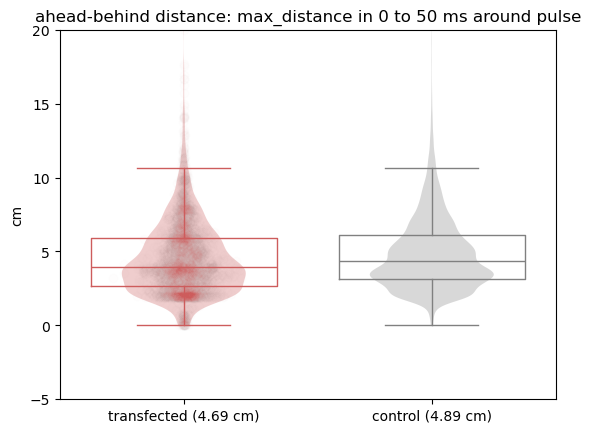

In [ ]:
from Analysis.utils import violin_scatter

measure = "max_distance"
# measure="spread"

rng = -65, 65
rng = 0, 50
val_list = []
ind_test = np.logical_and(plot_ind * 2 > rng[0], plot_ind * 2 < rng[1])
for i, (animal, ahead_behind) in enumerate(
    zip(
        compiled_results["animal"],
        compiled_results["ahead_behind"],
    )
):
    color = animal_style.loc[animal]["color"]

    ahead_behind = ahead_behind[:, ind_test]
    ahead_behind = np.clip(ahead_behind, -20, 20)
    if measure == "max_distance":
        val = np.max(np.abs(ahead_behind), axis=1)
    elif measure == "spread":
        val = np.max(ahead_behind, axis=1) - np.min(ahead_behind, axis=1)
    else:
        raise ValueError("Invalid measure: {}".format(measure))
    val = np.max(ahead_behind, axis=1) - np.min(ahead_behind, axis=1)
    # val = np.clip(val, -20, 20)
    xloc = i
    violin_scatter(val, pos=[xloc], color=color, alpha=0.2)
    # plt.scatter([xloc], np.mean(val), color=color, alpha=0.5,edgecolors="k",lw=2,s=50)

    bplot = plt.boxplot(val, positions=[xloc], showfliers=False, widths=0.75)
    plt.setp(bplot["boxes"], color=color)
    plt.setp(bplot["whiskers"], color=color)
    plt.setp(bplot["caps"], color=color)
    plt.setp(bplot["medians"], color=color)
    plt.setp(bplot["means"], color=color)
    print(animal, np.mean(val))

    val_list.append(val)

plt.xticks(
    np.arange(len(compiled_results["animal"])),
    [
        f"{a} ({np.round(np.mean(d),2)} cm)"
        for a, d in zip(compiled_results["animal"], val_list)
    ],
)
plt.ylabel("cm")
plt.ylim(-5, 20)
from scipy.stats import ttest_ind

print(ttest_ind(val_list[0], val_list[1]).pvalue)

plt.title(f"ahead-behind distance: {measure} in {rng[0]} to {rng[1]} ms around pulse")

In [5]:
compiled_results

,animal,state_response,entropy,mua,ahead_behind,coverage
0,transfected,"[[[0.5722029, 0.42779714], [0.5662296, 0.43377...","[[5.0910854, 5.1207933, 5.2044425, 5.221634, 5...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[5.471550680593521, 5.460515686064318, 5.4540...","[[214.8225871302323, 183.28899635882206, 185.2..."
1,control,"[[[0.9117164, 0.08828344], [0.9188915, 0.08110...","[[3.8174088, 3.8076973, 3.8029897, 3.80219, 3....","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[-3.013323789785743, -1.0852251839181688, -1....","[[37.44613904104967, 37.44613904104967, 37.446..."


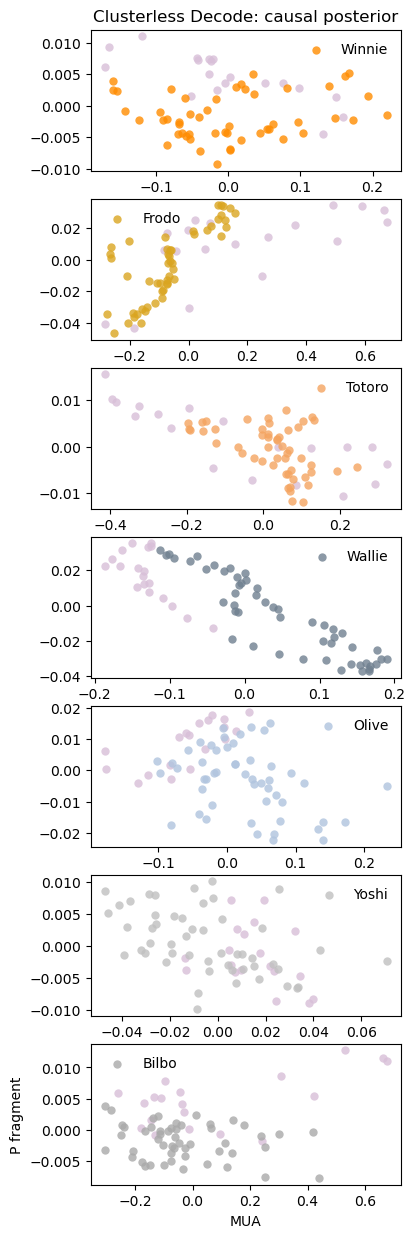

In [35]:
from Analysis.utils import smooth

fig, ax = plt.subplots(
    len(compiled_results),
    figsize=(4, 15),
)  # sharex=True,sharey=True)

ind = np.logical_and(plot_ind * 2 > 0, plot_ind * 2 < 40)
for i, (animal, state_response, entropy, mua, ahead_behind) in enumerate(
    compiled_results.values
):
    # if not animal =="Frodo": continue
    color = animal_style.loc[animal]["color"]
    yy_e = (
        entropy - np.mean(entropy, axis=1)[:, None]
    )  # / np.mean(entropy, axis=1)[:,None]
    yy_s = (np.array(mua) - np.mean(mua, axis=1)[:, None]) / np.mean(mua, axis=1)[
        :, None
    ]

    yy_e = np.mean(yy_e, axis=0)
    # yy_e = yy_e/np.var(yy_e)

    yy_s = np.mean(yy_s, axis=0)
    yy_s = smooth(yy_s, 5)

    # fragmented state
    yy_frag = (
        state_response[..., 1] - np.mean(state_response[..., 1], axis=1)[:, None]
    )  # / -np.mean(state_response[..., i], axis=1)[:, None]
    yy_frag, rng = bootstrap_traces(yy_frag, n_boot=n_boot)

    # ahead_behind = ahead_behind - np.mean(ahead_behind, axis=1)[:, None]
    yy_dist = ahead_behind  # / -np.mean(state_response[..., i], axis=1)[:, None]
    yy_dist, rng = bootstrap_traces(yy_dist, n_boot=n_boot)

    for plot_color, loc in zip(["thistle", color], [ind, ~ind]):
        y_plot = yy_frag[loc]
        # y_plot = yy_e[loc]
        # y_plot = yy_dist[loc]

        x_plot = yy_s[loc]
        # ax[i].scatter(yy_s, yy_e,alpha=1,color=color,label=animal)
        label = animal if plot_color == color else None
        ax[i].scatter(
            x_plot, y_plot, alpha=0.8, facecolor=plot_color, label=label, lw=0
        )
        # ax[i].set_xlim(-.03 + min(x_plot), .03+ max(x_plot))
        # ax[i].set_ylim(1.2 * min(y_plot), 1.1 * max(y_plot))
    plt.xlabel("MUA")
    plt.ylabel("P fragment")
    # plt.ylabel("Entropy")
    ax[0].set_title(f"Clusterless Decode: {posterior_fit} posterior")
    ax[i].legend(frameon=False)

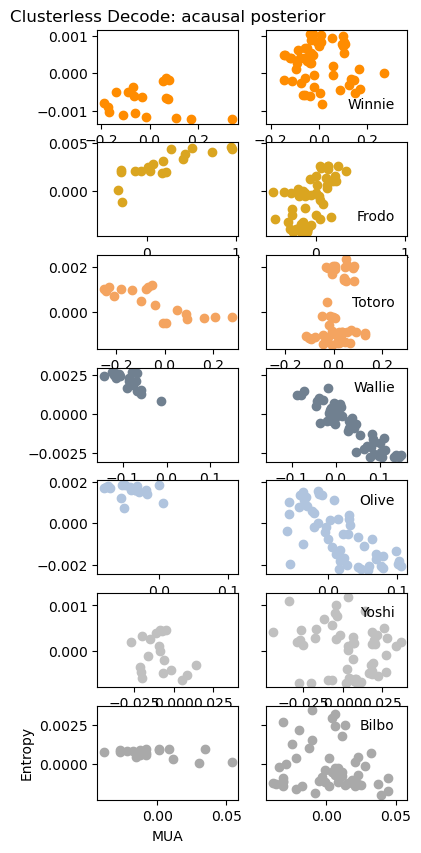

In [147]:
from Analysis.utils import smooth

fig, ax = plt.subplots(
    nrows=len(compiled_results),
    ncols=2,
    figsize=(4, 10),
    sharex="row",
    sharey="row",
)
#   sharex=True,sharey=True)

ind = np.logical_and(plot_ind * 2 > 0, plot_ind * 2 < 40)
for i, (animal, state_response, entropy, mua) in enumerate(compiled_results.values):
    color = animal_style.loc[animal]["color"]
    yy_e = (
        entropy - np.mean(entropy, axis=1)[:, None]
    )  # / np.mean(entropy, axis=1)[:,None]
    yy_e = np.mean(yy_e, axis=0)
    # yy_e = yy_e/np.var(yy_e)

    yy_s = np.array(mua) - np.mean(mua, axis=1)[:, None]
    # yy_s = yy_s/ np.mean(mua, axis=1)[:, None]
    yy_s = np.mean(yy_s, axis=0)
    yy_s = smooth(yy_s, 1)

    yy_frag = (
        state_response[..., 1] - np.mean(state_response[..., 1], axis=1)[:, None]
    )  # / -np.mean(state_response[..., i], axis=1)[:, None]
    yy_frag, rng = bootstrap_traces(yy_frag, n_boot=n_boot)

    for j, loc in enumerate([ind, ~ind]):
        y_plot = yy_frag[loc]
        # y_plot = yy_e[loc]
        x_plot = yy_s[loc]
        # ax[i].scatter(yy_s, yy_e,alpha=1,color=color,label=animal)
        ax[i, j].scatter(x_plot, y_plot, alpha=1, color=color, label=animal)
        # ax[i,j].set_xlim(-0.03 + min(x_plot), 0.03 + max(x_plot))
        # ax[i,j].set_ylim(1.2 * min(y_plot), 1.1 * max(y_plot))
    ax[i, -1].legend(frameon=False)

    ax[-1, 0].set_xlabel("MUA")
    ax[-1][0].set_ylabel("P fragment")
    ax[-1, 0].set_ylabel("Entropy")
    ax[0, 0].set_title(f"Clusterless Decode: {posterior_fit} posterior")

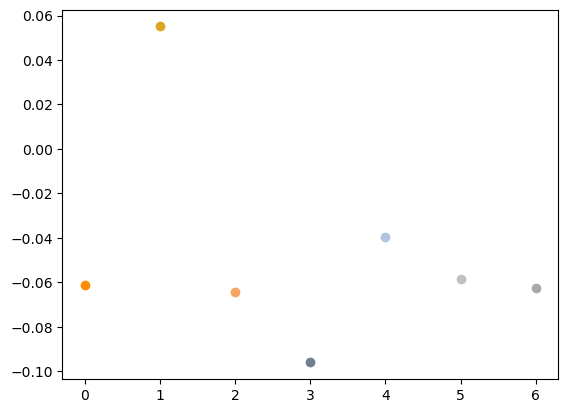

In [132]:
from Analysis.utils import smooth, violin_scatter

# fig, ax = plt.subplots(len(compiled_results), figsize=(4, 10),)#sharex=True,sharey=True)
for i, (animal, state_response, entropy, mua) in enumerate(compiled_results.values):
    color = animal_style.loc[animal]["color"]
    yy_e = (
        entropy - np.mean(entropy, axis=1)[:, None]
    )  # / np.mean(entropy, axis=1)[:,None]
    yy_s = (np.array(mua) - np.mean(mua, axis=1)[:, None]) / np.mean(mua, axis=1)[
        :, None
    ]

    # yy_e = np.mean(yy_e, axis=0)
    # yy_e = yy_e/np.var(yy_e)

    # yy_s = np.mean(yy_s, axis=0)
    yy_s = smooth(yy_s, 10)

    yy_frag = (
        state_response[..., 1] - np.mean(state_response[..., 1], axis=1)[:, None]
    )  # / -np.mean(state_response[..., i], axis=1)[:, None]
    # yy_frag, rng = bootstrap_traces(yy_frag, n_boot=n_boot)

    # C = np.array([np.corrcoef(yy_s[j],yy_e[j])[0][1] for j in range(len(yy_s))])

    # violin_scatter(C,color=color,pos=i)
    C = np.corrcoef(np.ravel(yy_s), np.ravel(yy_e))[0][1]
    plt.scatter([i], [C], color=color)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

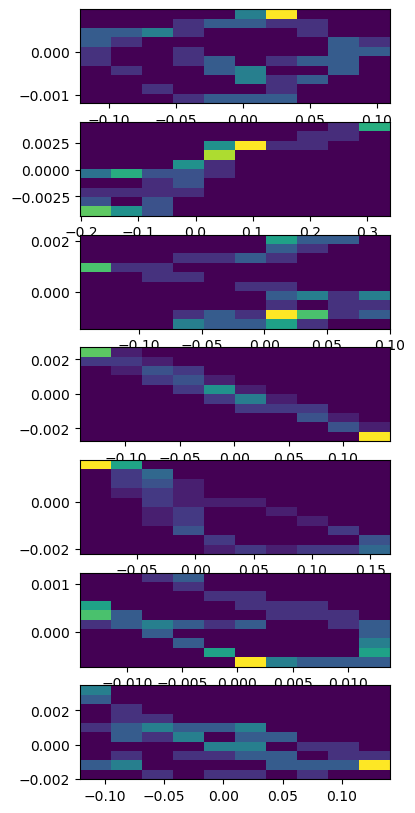

In [114]:
from Analysis.utils import smooth

fig, ax = plt.subplots(
    len(compiled_results),
    figsize=(4, 10),
)  # sharex=True,sharey=True)
for i, (animal, state_response, entropy, mua) in enumerate(compiled_results.values):
    color = animal_style.loc[animal]["color"]
    yy_e = (
        entropy - np.mean(entropy, axis=1)[:, None]
    )  # / np.mean(entropy, axis=1)[:,None]
    yy_s = (np.array(mua) - np.mean(mua, axis=1)[:, None]) / np.mean(mua, axis=1)[
        :, None
    ]
    yy_s = np.array([smooth(x, 5) for x in yy_s])

    # yy_e = np.mean(yy_e, axis=0)
    # yy_e = yy_e/np.var(yy_e)

    yy_s = np.mean(yy_s, axis=0)
    yy_s = smooth(yy_s, 10)

    yy_frag = (
        state_response[..., 1] - np.mean(state_response[..., 1], axis=1)[:, None]
    )  # / -np.mean(state_response[..., i], axis=1)[:, None]
    yy_frag, rng = bootstrap_traces(yy_frag, n_boot=n_boot)

    y_plot = yy_frag
    x_plot = yy_s
    # ax[i].scatter(yy_s, yy_e,alpha=1,color=color,label=animal)
    # ax[i].scatter(x_plot, y_plot, alpha=.1, color=color, label=animal,)
    # ax[i].hist2d(x_plot.flatten(), y_plot.flatten(), bins=100, cmap="viridis")
    H, bx, by = np.histogram2d(x_plot.flatten(), y_plot.flatten(), bins=10)
    H = H / H.sum()
    # H = np.log10(H)
    ax[i].pcolormesh(bx, by, H.T, cmap="viridis")
    ax[i].legend(frameon=False)
    # ax[i].set_xlim(-0.03 + min(x_plot), 0.03 + max(x_plot))
    # ax[i].set_ylim(1.2 * min(y_plot), 1.1 * max(y_plot))

In [8]:
spikes = ClusterlessDecodingV1().fetch_spike_data(key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, timestamps)
mua = np.bincount(spike_inds, minlength=len(timestamps))

In [10]:
mua.shape

(452530,)

In [11]:
k = ClusterlessDecodingV1().fetch("KEY", limit=1)
# distance = (ClusterlessDecodingV1() & k).get_ahead_behind_distance()
results = (ClusterlessDecodingV1() & k).fetch_results()

[2024-07-26 08:59:00,557][WARNING]: Skipped checksum for file with hash: 3598bfca-dca9-3f47-a1d3-d61d9b7432a5, and path: /stelmo/nwb/analysis/Winnie20220722/Winnie20220722_a8582655-3ad0-485b-a2bf-84affe3b56fb.nc


In [18]:
distance.shape, results.time.shape
import pandas as pd

df = pd.DataFrame({"time": results.time, "decode_distance": distance})
df = df.set_index("time")
df

,decode_distance
time,
1.658527e+09,130.586525
1.658527e+09,130.586525
1.658527e+09,128.621113
1.658527e+09,130.586525
1.658527e+09,130.586525
...,...
1.658528e+09,2.174051
1.658528e+09,2.174051
1.658528e+09,2.174051
